In [1]:
sys.path.insert(0, './common')

import numpy as np
from collections import deque
import sys
import cartpole
import qlearning_target_model

In [2]:
env = cartpole.CartPoleEnv()

CARTPOLE environment created.


In [3]:
model = qlearning_target_model.QLearning(4, 2, 100, lr=5e-4)
save_path = './models/qlearning.pth'
model.set_model_save_path(save_path)

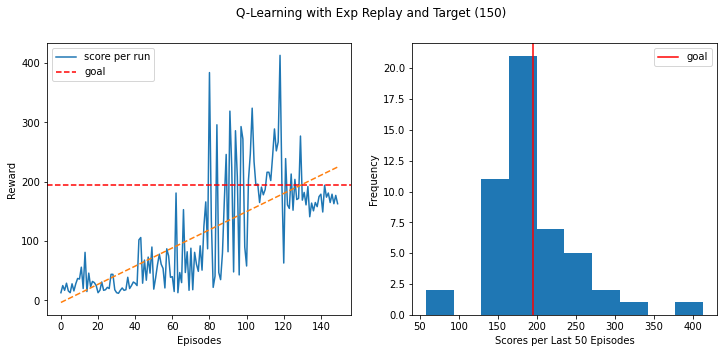

EPOCH: 149, total reward: 163.0, timestep: 163, epsilon: 0.04666666666666419


In [4]:
model.set_train_params(start_epsilon=1, batch_size=64, sync_interval=200)
model.train(env, 150)

In [ ]:
model.plot_train_memory()

In [ ]:
env = cartpole.CartPoleEnv()
model.test(env)

In [33]:
# Number of states
n_state = 4
# Number of actions
n_action = 2
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

# Get DQN results
model = DQN_replay(n_state, n_action, n_hidden, lr)

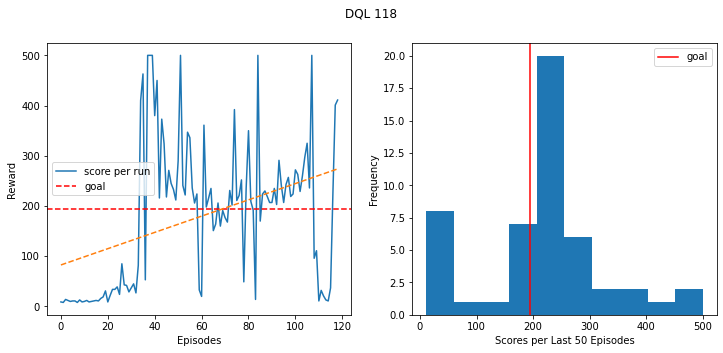

C:\Users\USER\AppData\Local\Temp\ipykernel_5060\604136276.py:53: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


KeyboardInterrupt: 

In [34]:
import random

EPOCH = 150
MEM_SIZE = 2500
MIN_EPSILON = .05
MAX_STEP = 500
MIN_BATCH = 32
GAMMA = 0.9

epsilon = 0.2

losses = []
all_rewards = []
all_timesteps = []
experiences = deque(maxlen=MEM_SIZE)

def loss_fn(pred, target):
    return torch.mean(0.5 * (pred - target) ** 2)

for i in range(EPOCH):
    state, is_done = env.reset()
    j = 0
    epoch_rewards = []
    while not is_done:
        j += 1
        state = torch.Tensor(state)

        qval = model.predict(state)
        if np.random.rand() > epsilon:
            # exploit
            action = np.argmax(qval.detach().numpy())
        else:
            # explore
            action = np.random.randint(0, 2)

        next_state, reward, is_done = env.step(action)
        epoch_rewards.append(reward)
    
        state2 = torch.Tensor(next_state)
        current_exp = (state.detach().numpy()[0], action, state2.detach().numpy()[0], reward, is_done)
        experiences.append(current_exp)

        state = next_state

        if len(experiences) >= MIN_BATCH:
            model.replay(experiences, MIN_BATCH, GAMMA)

    current_reward = np.sum(epoch_rewards)
    all_rewards.append(current_reward)
    all_timesteps.append(j)
    plot_res(all_rewards, 'DQL {}'.format(i))
    epsilon = max(epsilon * 0.99, 0.01)

env.close()

In [39]:
# Install packages
import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import random

import time

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

In [60]:
import torch
from torch.autograd import Variable
class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                            torch.nn.Linear(state_dim, hidden_dim),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim, hidden_dim*2),
                            torch.nn.LeakyReLU(),
                            torch.nn.Linear(hidden_dim*2, action_dim)
                    )
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr)



    def update(self, state, y):
        print('UPDATE WEIGHTS')
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

# Expand DQL class with a replay function.
class DQN_replay(DQN):
    #old replay function
    #def replay(self, memory, size, gamma=0.9):
        #""" Add experience replay to the DQN network class. """
        # Make sure the memory is big enough
        #if len(memory) >= size:
            #states = []
            #targets = []
            # Sample a batch of experiences from the agent's memory
            #batch = random.sample(memory, size)
            
            # Extract information from the data
            #for state, action, next_state, reward, done in batch:
                #states.append(state)
                # Predict q_values
                #q_values = self.predict(state).tolist()
                #if done:
                    #q_values[action] = reward
                #else:
                    #q_values_next = self.predict(next_state)
                    #q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
                #targets.append(q_values)

            #self.update(states, targets)
    
    #new replay function
    def replay(self, memory, size, gamma=0.9):
        """New replay function"""
        #Try to improve replay speed
        if len(memory)>=size:
            print('UPDATE REPLAY')
            batch = random.sample(memory,size)
            batch_t = list(map(list, zip(*batch))) #Transpose batch list
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
        
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
        
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
        
            all_q_values = self.model(states) # predicted q_values of all states
            all_q_values_next = self.model(next_states)
            #Update q values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            
            self.update(states.tolist(), all_q_values.tolist())

# Number of states
n_state = 4
# Number of actions
n_action = 2
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

# Get DQN results
model = DQN_replay(n_state, n_action, n_hidden, lr)

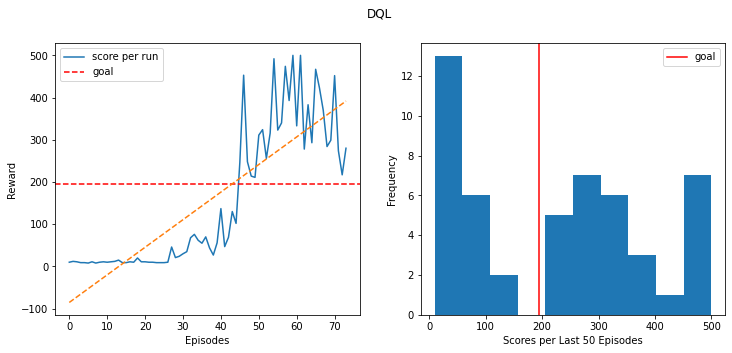

episode: 74, total reward: 280.0
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REP

C:\Users\USER\AppData\Local\Temp\ipykernel_22556\1043154359.py:86: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]


UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS
UPDATE REPLAY
UPDATE WEIGHTS

KeyboardInterrupt: 

In [61]:
gamma=0.9
epsilon=0.3
eps_decay=0.99
replay=False
replay_size=20 
title = 'DQL'
verbose = True

final = []
memory = []
episode_i=0
sum_total_replay_time=0
for episode in range(episodes):
    episode_i+=1

    # Reset state
    state, done = env.reset()
    total = 0
    
    while not done:
        # Implement greedy search policy to explore the state space
        if random.random() < epsilon:
            action = random.randint(0, 1)
        else:
            q_values = model.predict(state[0])
            action = torch.argmax(q_values).item()

        # Take action and add reward to total
        next_state, reward, done = env.step(action)
        
        # Update total and memory
        total += reward
        memory.append((state[0], action, next_state[0], reward, done))
        q_values = model.predict(state[0]).tolist()

        t0=time.time()
        # Update network weights using replay memory
        model.replay(memory, replay_size, gamma)
        t1=time.time()
        sum_total_replay_time+=(t1-t0)

        state = next_state
    
    # Update epsilon
    epsilon = max(epsilon * eps_decay, 0.01)
    final.append(total)
    plot_res(final, title)
    
    if verbose:
        print("episode: {}, total reward: {}".format(episode_i, total))
        if replay:
            print("Average replay time:", sum_total_replay_time/episode_i)

In [53]:
env = cartpole.CartPoleEnv()
env.reset()

CARTPOLE environment created.


(array([[ 0.0235946 , -0.04082493,  0.00571128, -0.04489507]],
       dtype=float32),
 False)

In [11]:
env = gym.make("CartPole-v1")
state = env.reset()
np.array([state])

array([[-0.02639886, -0.03213628,  0.0056489 ,  0.00419959]],
      dtype=float32)

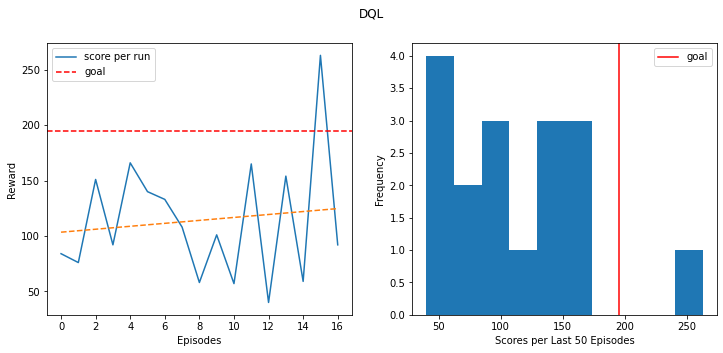

C:\Users\USER\AppData\Local\Temp\ipykernel_22556\875284873.py:78: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  qvals[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()] = rewards[is_dones_indices.tolist()]


KeyboardInterrupt: 

In [68]:
import random
from collections import deque

import numpy as np
import torch

import env_interface
import model_interface
import plot

input_layer = 4
hidden_layer = 100
output_layer = 2

model = torch.nn.Sequential(
    torch.nn.Linear(input_layer, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, output_layer),
)
loss_fn = torch.nn.MSELoss()
input_layer = input_layer
output_layer = output_layer
epsilon = 1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


mem_size=2500
start_epsilon=.2
min_epsilon=.05
max_step=500
batch_size=20
gamma=.9
experiences = []
train_losses = []

# def set_train_params(mem_size=2500, start_epsilon=1, min_epsilon=.05, max_step=500, batch_size=512, gamma=.9):
#     self.mem_size = mem_size
#     self.epsilon = start_epsilon
#     self.min_epsilon = min_epsilon
#     self.max_step = max_step
#     self.batch_size = batch_size
#     self.gamma = gamma

# set_train_params()
# reset_train_memory()
    
def update_weights(model, state, y):
    y_pred = model(torch.Tensor(state))
    loss = loss_fn(y_pred, torch.Tensor(y))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

def update_model(model):
    batch_t = list(map(list, zip(*experiences)))
    states = batch_t[0]
    actions = batch_t[1]
    rewards = batch_t[3]
    next_states = batch_t[2]
    is_dones = batch_t[4]

    states = torch.Tensor(states)
    actions_tensor = torch.Tensor(actions)
    rewards = torch.Tensor(rewards)
    next_states = torch.Tensor(next_states)
    is_dones_tensor = torch.Tensor(is_dones)

    is_dones_indices = torch.where(is_dones_tensor == True)[0]

    qvals = model(states)
    qvals_next = model(next_states)

    qvals[range(len(qvals)),actions] = rewards + gamma * torch.max(qvals_next, axis=1).values
    qvals[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()] = rewards[is_dones_indices.tolist()]

    update_weights(model, states.tolist(), qvals.tolist())

n_state = 4
# Number of actions
n_action = 2
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

# Get DQN results
model = DQN_replay(n_state, n_action, n_hidden, lr)

def train(env: env_interface.EnvInterface, epoch=1000, reset_memory=False):
    gamma=0.9
    epsilon=0.3
    eps_decay=0.99
    replay=False
    replay_size=20 
    title = 'DQL'
    verbose = True

    final = []
    memory = []
    episode_i=0
    sum_total_replay_time=0
    for episode in range(episodes):
        episode_i+=1

        # Reset state
        state, done = env.reset()
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = random.randint(0, 1)
            else:
                q_values = model.predict(torch.Tensor(state[0]))
                action = torch.argmax(q_values).item()

            # Take action and add reward to total
            next_state, reward, done = env.step(action)
            
            # Update total and memory
            total += reward
            experiences.append((state[0], action, next_state[0], reward, done))

            if len(experiences) > batch_size:
                update_model(model.model)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_res(final, title)

    env.close()

def test(env: env_interface.EnvInterface):
    state, is_done = env.reset()
    timestep = 0
    total_reward = 0
    while not is_done:
        timestep += 1
        preds = model(torch.Tensor(state)).detach().numpy()

        action = np.argmax(preds)
        state, reward, is_done = env.step(action)
        total_reward += reward

    env.close()
    return total_reward, timestep

train(env)


In [11]:
model = qlearning_model.QLearning(4, 2, 100, lr=5e-4)
save_path = './models/qlearning.pth'
model.set_model_save_path(save_path)

In [4]:
model.load_model()

No model available


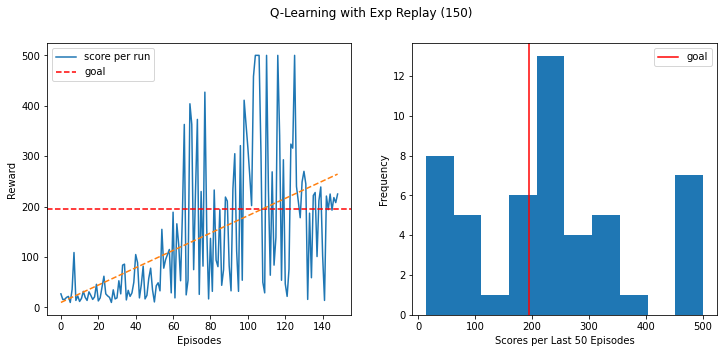

EPOCH: 149, total reward: 172.0, timestep: 172, epsilon: 0.22368867397864742


In [12]:
model.set_train_params(start_epsilon=1, batch_size=64)
model.train(env, 150)

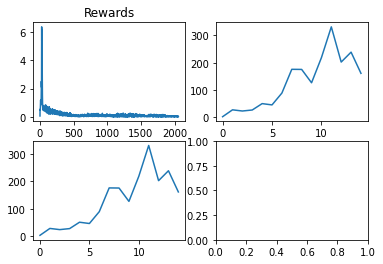

In [13]:
model.plot_train_memory()

In [30]:
env = cartpole.CartPoleEnv()
model.test(env)

CARTPOLE environment created.


(179.0, 179)

In [11]:
env.close()